In [ ]:
import os
import numpy as np
import pandas as pd
import wave
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

## Initial agent-based simulation from Copilot

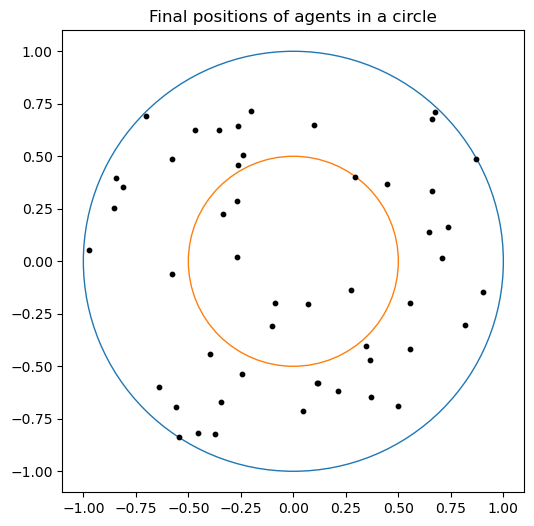

In [6]:
# Parameters
num_agents = 50
num_steps = 100
outer_circle_radius = 1
inner_circle_radius = 0.5
step_std = 0.02  # Standard deviation for Gaussian steps

# Initialize agent positions uniformly within the circle
angles = np.random.uniform(0, 2*np.pi, num_agents)
radii = outer_circle_radius * np.sqrt(np.random.uniform(0, 1, num_agents))
positions = np.stack([radii * np.cos(angles), radii * np.sin(angles)], axis=1)

# Simulation loop
trajectories = [positions.copy()]
for _ in range(num_steps):
    steps = np.random.normal(0, step_std, positions.shape)
    new_positions = positions + steps
    # Check if new positions are within the circle
    distances = np.linalg.norm(new_positions, axis=1)
    inside = distances <= outer_circle_radius
    # Only update positions that stay inside
    positions[inside] = new_positions[inside]
    trajectories.append(positions.copy())

# Plot final positions and the circle
fig, ax = plt.subplots(figsize=(6,6))
outer_circle_plot = plt.Circle((0, 0), outer_circle_radius, color='tab:blue', fill=False)
inner_circle_plot = plt.Circle((0, 0), inner_circle_radius, color='tab:orange', fill=False)
ax.add_artist(inner_circle_plot)
ax.add_artist(outer_circle_plot)
ax.scatter(positions[:,0], positions[:,1], color='k',s=10)
ax.set_aspect('equal')
plt.xlim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.ylim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.title("Final positions of agents in a circle")
plt.show()

## Define the Bird class

In [54]:
class Bird:
    def __init__(self, 
                 audio_path,
                 individual_label,
                 species_label,
                 step_std=0.05, 
                 inner_circle_radius=0.25,
                 ):
        self._step_std = step_std
        self._audio_path = audio_path
        self._individual_label = individual_label
        self._species_label = species_label
        # lists for tracking
        self._individual_history = []
        self._species_history = []
        # set up radii
        self._outer_circle_radius = 1.
        self._inner_circle_radius = inner_circle_radius
        # set up position
        angles = np.random.uniform(0, 2*np.pi)
        radii = outer_circle_radius * np.sqrt(np.random.uniform(0, 1))
        self._position = np.array([radii * np.cos(angles), radii * np.sin(angles)])
        # store duration of audio file
        with wave.open(audio_path, 'rb') as wf:
            frames = wf.getnframes()
            rate = wf.getframerate()
            self._duration = frames / float(rate)

    # Make a potential move each time step
    def step(self):
        step = np.random.normal(0, self._step_std, 2)
        # Move if not leaving outer circle
        if np.linalg.norm(self._position + step) <= self._outer_circle_radius:
            self._position += step
        # Move opposite if still inside outer circle
        elif np.linalg.norm(self._position - step) <= self._outer_circle_radius:
            self._position -= step

    # Record vocalization if inside inner circle
    def record(self):
        if np.linalg.norm(self._position) <= self._inner_circle_radius:
            self._individual_history.append(self._individual_label)
            self._species_history.append(self._species_label)
            # Play audio
            print(f"Playing audio from {self._audio_path} at position {self._position}")
        else:
            self._individual_history.append(0)
            self._species_history.append(0)

    # Make the vocalization
    def vocalize(self, num_seconds):
        offset = np.random.uniform(0, self._duration - num_seconds)
        voice, sr = librosa.load(self._audio_path, sr=None, 
                                 offset=offset, duration=num_seconds)
        return voice, sr



## Bird-based simulation

In [57]:
num_time_steps = 20
step_std = 0.05
inner_circle_radius_scalar = 0.25
wav_files = [f for f in os.listdir('data/warblrb') if f.endswith('.wav')]

# Create a list of Bird agents
birds = []
for i in range(num_agents):
    bird = Bird(
        step_std=step_std,
        # audio_path=f"audio/bird_{i}.wav",
        audio_path=f"data/warblrb/{wav_files[i%3]}",
        individual_label=i+1,
        species_label="species_A",
        inner_circle_radius=inner_circle_radius,
    )
    birds.append(bird)

# Run the simulation for num_steps
for_animation = []
for _ in range(num_steps):
    for bird in birds:
        bird.step()
        bird.record()
    for_animation.append(np.array([bird._position for bird in birds]))

Playing audio from data/warblrb/001277e4-24c2-4b8e-a6a8.wav at position [-0.10251642 -0.22060625]
Playing audio from data/warblrb/000e088a-69f7-4d7a-ba7b.wav at position [-0.0116362  -0.16038097]
Playing audio from data/warblrb/001277e4-24c2-4b8e-a6a8.wav at position [-0.1749565  -0.17049119]
Playing audio from data/warblrb/0011e7f9-ec1e-4f3a-a70f.wav at position [0.04262906 0.21108082]
Playing audio from data/warblrb/001277e4-24c2-4b8e-a6a8.wav at position [-0.11835714 -0.21640918]
Playing audio from data/warblrb/000e088a-69f7-4d7a-ba7b.wav at position [ 0.02139697 -0.22868543]
Playing audio from data/warblrb/001277e4-24c2-4b8e-a6a8.wav at position [-0.04111461 -0.18989952]
Playing audio from data/warblrb/000e088a-69f7-4d7a-ba7b.wav at position [ 0.09260758 -0.21269172]
Playing audio from data/warblrb/0011e7f9-ec1e-4f3a-a70f.wav at position [0.11414221 0.17801588]
Playing audio from data/warblrb/0011e7f9-ec1e-4f3a-a70f.wav at position [-0.08948162 -0.22998014]
Playing audio from data/

## Make an animation

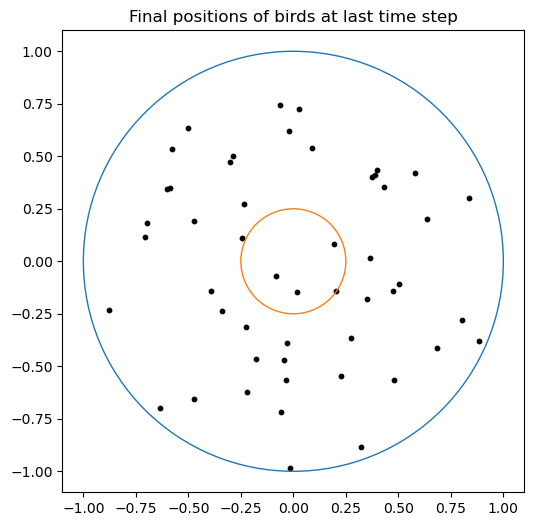

In [39]:
final_positions = np.array([bird._position for bird in birds])
plt.figure(figsize=(6,6))
plt.scatter(final_positions[:,0], final_positions[:,1], color='k', s=10)
outer_circle = plt.Circle((0, 0), outer_circle_radius, color='tab:blue', fill=False)
inner_circle = plt.Circle((0, 0), inner_circle_radius, color='tab:orange', fill=False)
plt.gca().add_artist(outer_circle)
plt.gca().add_artist(inner_circle)
plt.xlim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.ylim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.gca().set_aspect('equal')
plt.title("Final positions of birds at last time step")
plt.show()

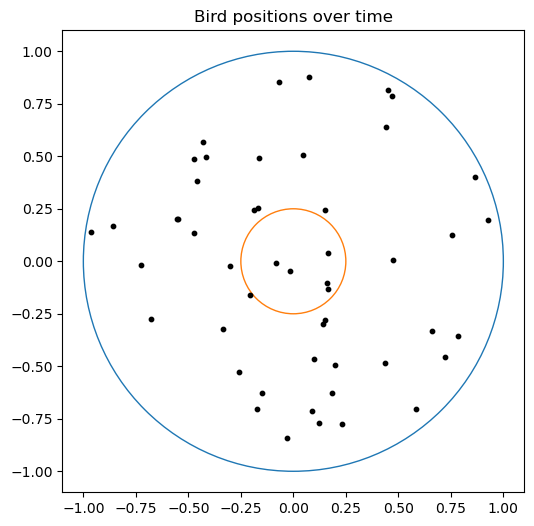

In [40]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6,6))
outer_circle = plt.Circle((0, 0), outer_circle_radius, color='tab:blue', fill=False)
inner_circle = plt.Circle((0, 0), inner_circle_radius, color='tab:orange', fill=False)
ax.add_artist(outer_circle)
ax.add_artist(inner_circle)
scat = ax.scatter(for_animation[0][:,0], for_animation[0][:,1], color='k', s=10)
ax.set_aspect('equal')
plt.xlim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.ylim(-outer_circle_radius-0.1, outer_circle_radius+0.1)
plt.title("Bird positions over time")

def update(frame):
    scat.set_offsets(for_animation[frame])
    return scat,

ani = FuncAnimation(fig, update, frames=len(for_animation), interval=100, blit=True)
plt.show()
ani.save('bird_simulation.mp4', writer='ffmpeg', fps=10)

## Miscellaneous

In [ ]:
i = np.random.randint(0, len(birds))
audio, sr = birds[i].vocalize(5)  # Get audio data and sample rate
Audio(audio, rate=sr)

In [45]:
warblrb = pd.read_csv('data/warblrb/warblrb10k_public_metadata.csv')
warblrb.head()

,itemid,hasbird
0,759808e5-f824-401e-9058,1
1,1d94fc4a-1c63-4da0-9cac,1
2,bb0099ce-3073-4613-8557,1
3,c4c67e81-9aa8-4af4-8eb7,1
4,ab322d4b-da69-4b06-a065,0
